In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.5f' % x) #prevent scientific number display
%matplotlib inline

# Import Data

In [2]:
dataset = pd.read_excel('Dataset.xlsx', sheet_name = 'Data Set')
market = pd.read_excel('Dataset.xlsx', sheet_name = 'Market')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Market ID          720 non-null    int64
 1   Year               720 non-null    int64
 2   Month              720 non-null    int64
 3   Rent               720 non-null    int64
 4   Fees               720 non-null    int64
 5   Starting Units     720 non-null    int64
 6   New Units          720 non-null    int64
 7   Lost Units         720 non-null    int64
 8   Total Nights Sold  720 non-null    int64
dtypes: int64(9)
memory usage: 50.8 KB


In [4]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Market    20 non-null     object
 1   MarketId  20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 448.0+ bytes


# Data Processing

In [5]:
# join the datasets (dataset & market)

col_drop = ['MarketId','Market ID']

org_data_set = dataset.merge(market, how = 'left', left_on = 'Market ID',
            right_on = 'MarketId' ).drop(columns = col_drop )

org_data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 0 to 719
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Year               720 non-null    int64 
 1   Month              720 non-null    int64 
 2   Rent               720 non-null    int64 
 3   Fees               720 non-null    int64 
 4   Starting Units     720 non-null    int64 
 5   New Units          720 non-null    int64 
 6   Lost Units         720 non-null    int64 
 7   Total Nights Sold  720 non-null    int64 
 8   Market             720 non-null    object
dtypes: int64(8), object(1)
memory usage: 56.2+ KB


### Aggregate Transformantion

In [6]:
# Create date index, order columns and groups by date eliminating Market

from pandas.tseries.offsets import MonthEnd

org_data_set['YearMonth'] = org_data_set['Year'].astype(str)+org_data_set['Month'].astype(str)

org_data_set['Date']= pd.to_datetime(org_data_set['YearMonth'], format="%Y%m") + MonthEnd(1)

col_drop1 = ['YearMonth']
#col_drop1 = ['Year','Month', 'YearMonth'] 

column_order = ['Month','Rent','Fees','Total Nights Sold',
               'Starting Units','New Units','Lost Units']

org_data_set = org_data_set.drop(columns = 'Month').groupby('Date').sum()

org_data_set['Month'] = pd.DatetimeIndex(org_data_set.index).month
org_data_set = org_data_set.reindex(columns = column_order)#.set_index(['Date']).sort_index()

org_data_set.head()

,Month,Rent,Fees,Total Nights Sold,Starting Units,New Units,Lost Units
Date,,,,,,,
2019-01-31,1,2819632,768131,21058,1965,77,66
2019-02-28,2,3293731,802415,23777,1994,68,49
2019-03-31,3,5903504,1675303,33748,2020,411,41
2019-04-30,4,6061874,1909305,33399,2389,133,43
2019-05-31,5,6938249,2283756,37130,2463,77,55


<AxesSubplot:xlabel='Date'>

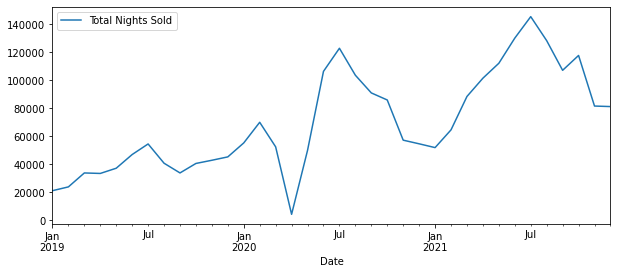

In [7]:
#Nights graph to observe data
org_data_set['Total Nights Sold'].plot.line( figsize = (10,4), legend = True )

In [8]:
# Set up data to calculate outlier months in 2020 (COVID) at Market level.
pd.options.mode.chained_assignment = None  # default='warn'

#Update as needed:
#----------------------------------------------------------------|
time_range_comparable = slice('2021-02-28','2021-06-30')# needs an additional month
time_covid_start = '2020-02-29'
time_covid_period = slice('2020-02-29','2020-05-31')
col_drop2 = ['Starting Units','New Units','Lost Units']
col_drop3 = ['Rent','Fees','Total Nights Sold']

#Gets the data needed for the calculation comparable and covid period
comparable_period = org_data_set.loc[(time_range_comparable),:].reset_index().drop(columns = col_drop2 )
time_covid_start = org_data_set.loc[(time_covid_start),:]
unchanged_cols_covid_2020 = org_data_set.loc[(time_covid_period),:].reset_index().drop(columns = col_drop3 )
#----------------------------------------------------------------|

#Update as needed:
#---------------------------------------------------------------|
col1 = 'Rent'
col2 = 'Fees'
col3 = 'Total Nights Sold'
delta_col1_name = 'Rent_delta'
delta_col2_name = 'Fees_delta'
delta_col3_name = 'Total Nights Sold_delta'

#Creates the % change from month to month
comparable_period[delta_col1_name] = comparable_period[col1].pct_change(periods = 1)
comparable_period[delta_col2_name] = comparable_period[col2].pct_change(periods = 1)
comparable_period[delta_col3_name] = comparable_period[col3].pct_change(periods = 1)
comparable_period = comparable_period.drop(columns = col_drop3).dropna()
#---------------------------------------------------------------|

#Creates date column for covid period
covid_dates = unchanged_cols_covid_2020.iloc[:,0]

In [9]:
# Recalculation of  outlier columns in months of 2020 (COVID)
#----------------------------------------------------------------|
#Update as needed:
col = 'Total Nights Sold'
col_delta = col+'_delta'

#adds values to be transforms into lists
attribute = list()
attribute = [time_covid_start[col]]
pct_change = list()
pct_change = [x for x in comparable_period[col_delta]]
covid_dates = [x for x in covid_dates]
covid_outlier_ouput = dict()
    
for i in range(len(pct_change)):
    if i == 0: attribute.append(attribute[0]*(1+pct_change[0]))  
    else: attribute.append(attribute[i]*(1+pct_change[i]))
print('Recalculated'+' '+col+':',attribute[1:])
        
for i in range(len(attribute)-1):
    covid_outlier_ouput[covid_dates[i]] = attribute[i+1]
#----------------------------------------------------------------|
    
#----------------------------------------------------------------|
#Update as needed:
column_order1 = ['Month','Rent','Fees','Total Nights Sold',
               'Starting Units','New Units','Lost Units']

unchanged_cols_covid_2020[col] = unchanged_cols_covid_2020.Date.map(covid_outlier_ouput)

updated_cols_covid_2020 = unchanged_cols_covid_2020.set_index(['Date'],
                                drop = True).reindex(columns = column_order1)
updated_cols_covid_2020
#----------------------------------------------------------------|

Recalculated Total Nights Sold: [95896.15230957432, 110065.53608758264, 121643.39560847952, 141139.98211492898]


,Month,Rent,Fees,Total Nights Sold,Starting Units,New Units,Lost Units
Date,,,,,,,
2020-02-29,2,NaN,NaN,95896.15231,5887,360,111
2020-03-31,3,NaN,NaN,110065.53609,6145,98,99
2020-04-30,4,NaN,NaN,121643.39561,6141,34,133
2020-05-31,5,NaN,NaN,141139.98211,6013,59,122


In [10]:
#Get data by columns without outlier and appends updated outlier data.

Agg_df = org_data_set.drop( index = covid_dates)
Agg_df = Agg_df.append(updated_cols_covid_2020).sort_index()

<AxesSubplot:xlabel='Date'>

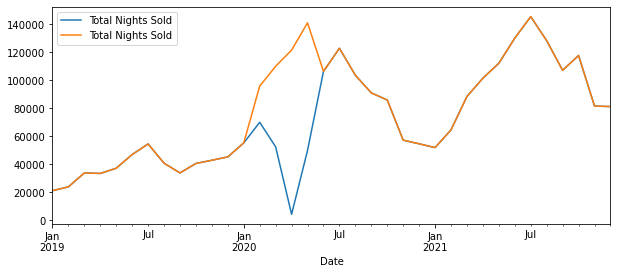

In [11]:
org_data_set['Total Nights Sold'].plot.line( figsize = (10,4), legend = True )
Agg_df['Total Nights Sold'].plot.line( figsize = (10,4), legend = True )

In [12]:
#caluculate inventory
Agg_df['Inventory'] = (Agg_df['Starting Units']+Agg_df['New Units'])-Agg_df['Lost Units']

#adds period col
Agg_df['Period'] = np.arange(len(Agg_df))

#Dummy Variables
Agg_df = pd.get_dummies(Agg_df, columns = ['Month'], drop_first = True)

In [13]:
data = Agg_df['Total Nights Sold'].to_frame()
data.head(5)

,Total Nights Sold
Date,
2019-01-31,21058.00000
2019-02-28,23777.00000
2019-03-31,33748.00000
2019-04-30,33399.00000
2019-05-31,37130.00000


In [14]:
#set frequnecy of index to monthly (end of month - 'M')

data.index.freq = 'M'

data.index

DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31',
               '2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', freq='M')

In [15]:
# Train test split
#size = int(len(x)*0.8)
size = 24
train = data['Total Nights Sold'].iloc[:size]
test = data['Total Nights Sold'].iloc[size-1:]

# Cyclical Trend Decomposition

In [16]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [17]:
#get Generalizrd trend and cycles of Nights Sold
#lamb=1600 for qurterly data
#lamb=6.25 for annual data
#lamb=129600 for monthly data

nights_cycle, nights_trend = hpfilter(data['Total Nights Sold'], lamb=129600 )

#data['trend'] = nights_trend 
#data['nights_cycle'] = nights_cycle

<AxesSubplot:xlabel='Date'>

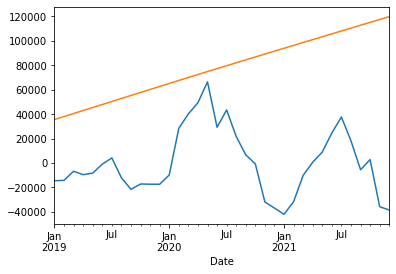

In [18]:
nights_cycle.plot()
nights_trend.plot()

In [19]:
#naive seasonal decomposition function
from statsmodels.tsa.seasonal import seasonal_decompose

def nsd_f(df):
    decomposition_mul = seasonal_decompose(df, model = 'multiplicative')
    trend = decomposition_mul.trend
    seasonal = decomposition_mul.seasonal
    residual = decomposition_mul.resid
 
    plt.figure(figsize=(8,6))
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='S')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Res',linestyle='dashed' )
    plt.legend(loc='upper left')
    plt.tight_layout()

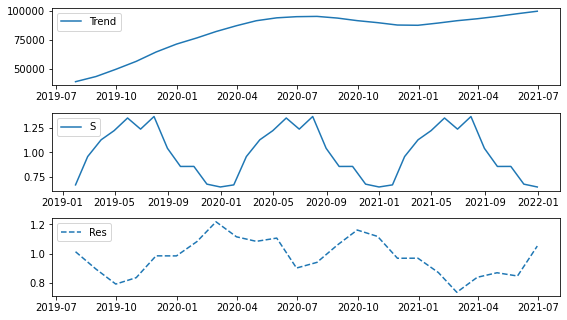

In [20]:
nsd_f(data)

# Simple Moving Average (SMA)

In [21]:
data['6-months-SMA'] = data['Total Nights Sold'].rolling(window = 6).mean()
data['12-months-SMA'] = data['Total Nights Sold'].rolling(window = 12).mean()

<AxesSubplot:xlabel='Date'>

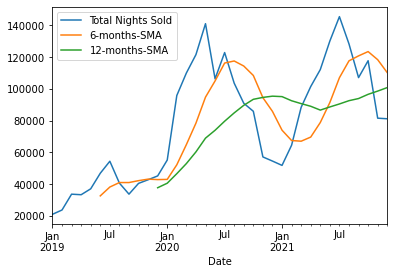

In [22]:
data.plot()

# Simple Exponential Smoothing

In [23]:
#No trnd or seasonality
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [24]:
#Manual calc of alpha
span = 12
alpha = span/(12+1)

In [25]:
#Method 1
#data['EWMA12'] = data['Total Nights Sold'].ewm(alpha = alpha, adjust=False).mean()

In [26]:
#Method 2
ses = SimpleExpSmoothing(data['Total Nights Sold'])

ses_fitted = ses.fit(optimized=True)

data['SES'] = ses_fitted.fittedvalues.shift(-1)

C:\Users\AlexTejerizo\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\AlexTejerizo\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


# Double Exponential Smoothing

In [27]:
#Trend without seasonality
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [28]:
des = ExponentialSmoothing(data['Total Nights Sold'], trend ='add')

des_fitted = des.fit(optimized=True)

data['DES'] = des_fitted.fittedvalues.shift(-1)

C:\Users\AlexTejerizo\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


# Triple Exponential Smoothing

In [29]:
#Trend with seasonality
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [30]:
tes = ExponentialSmoothing(data['Total Nights Sold'], trend='add', seasonal ='add', seasonal_periods=12)
tes_fitted = tes.fit(smoothing_level=alpha)

data['TES'] = tes_fitted.fittedvalues.shift(-1)

C:\Users\AlexTejerizo\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<AxesSubplot:xlabel='Date'>

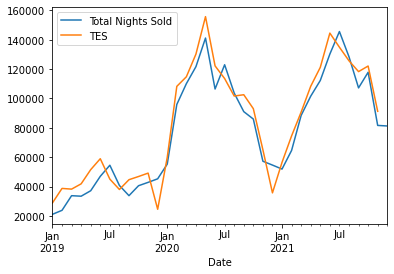

In [31]:
data[['Total Nights Sold','TES']].plot()

### Forecast

In [32]:
tes = ExponentialSmoothing(train, trend='add', seasonal='add',seasonal_periods=12 )

tes_fitted = tes.fit(use_boxcox=True)

test_pred = tes_fitted.forecast(12)

C:\Users\AlexTejerizo\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\AlexTejerizo\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1112: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  warnings.warn(


<AxesSubplot:xlabel='Date'>

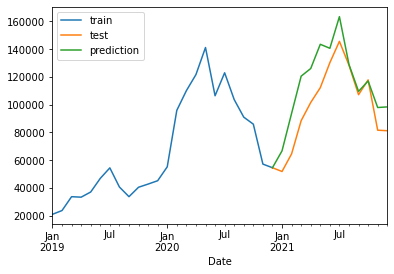

In [48]:
train.plot(legend = True, label = 'train')
test.plot(legend = True, label ='test')
pd.concat([train[len(train)-1:],test_pred]).plot(legend = True,label ='prediction')

In [46]:
from sklearn import metrics
#Train performance
print('mape: %.2f' % metrics.mean_absolute_percentage_error(test_pred,test[1:]))
print('rmse: %.0f' % np.sqrt(metrics.mean_squared_error(test_pred,test[1:])))
print('mean: %.0f' % test[1:].mean())
print('Std Dev: %.0f' % np.sqrt(test[1:].var()))

mape: 0.15
rmse: 19712
mean: 100896
Std Dev: 28125
